# Testing the quality of the posterior: seize the moment 
Marco Raveri (marco.raveri@unige.it) 

In this notebook we show how to perform moment based tests for the quality of the posterior estimate from different MCMC chains.

We perform these tests considering several different chains obtained with the same sampling scheme but what we discuss can be readily applied to pools of chains from different sources or to two chains obtained with different sampling settings.

In [1]:
# we start by importing several libraries:
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'../..')))
from getdist import plots, MCSamples
from getdist.gaussian_mixtures import GaussianND
import getdist
getdist.chains.print_load_details = False
import scipy
import matplotlib.pyplot as plt
import numpy as np
# import the tensiometer tools that we need:
from tensiometer import utilities
from tensiometer import chains_convergence

2023-10-01 20:31:40.543728: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We now import the chain with the parameter posteriors.

Notice that we have removed many parameters from the chains since they were irrelevant to the example.
The chains are already fully polished. Burn in has been removed and the samples have been thinned (to save space on github).

In [2]:
# load the chains (remove no burn in since the example chains have already been cleaned):
chains_dir = './../../test_chains/'
# the DES Y1 3x2 chain:
chain = getdist.mcsamples.loadMCSamples(file_root=chains_dir+'DES', no_cache=True)

## The short story

We start with a pool of chains. For definitness we assume that we have two. The way in which we have obtained does not truly matter. 
The only thing that matters is that they should be from the same distribution.

In [3]:
chains = utilities.get_separate_mcsamples(chain)[:2]

The full dimensional Gelman Rubin test is given by:

In [4]:
GR_val, GR_par = chains_convergence.GR_test(chains)
print(GR_val)

0.020983515202118053


that tells us that the mean of the distribution is known to 2% of the variance.

The same type of test applied to the second order moments:

In [5]:
GR2_val, GR2_par = chains_convergence.GRn_test(chains, n=2)
print(GR2_val)

0.01670447175092968


tells us that we know the covariance to below 1%, in units of the covariance of the covariance.
Notice that these tests are random in nature and not sufficient (but rather only necessary) so we should always look at the worse number that we obtain as a global indication for the quality of the posterior. 

It is possible to go higher with moments order to test the skewness but it all becomes computationally more expensive as the order raises.

Since these tests are multidimensional they report the parameter combination that is affected by sampling errors.
The mode can be visualized to understand what are the parameters that are most influenced by these errors.

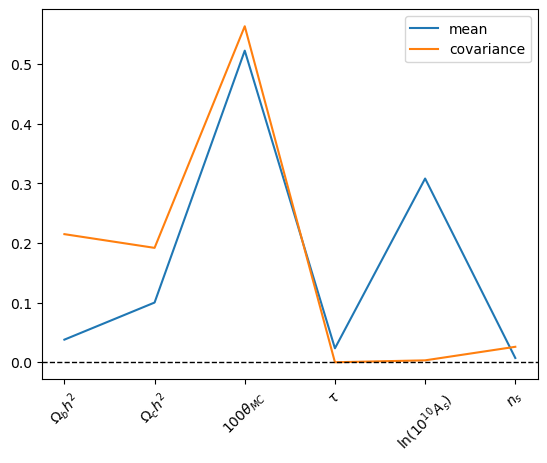

In [6]:
running_names = chain.getParamNames().getRunningNames()
plt.plot(GR_par**2, label='mean')
plt.plot(GR2_par**2, label='covariance')
plt.xticks(np.arange(len(running_names)), [ '$'+nam.label+'$' for nam in chain.getParamNames().parsWithNames(running_names)], rotation=45)
plt.axhline(0.0, ls='--', lw=1., color='k')
plt.legend();

Which tells us the parameters that the chains most disagree on.

## The long story:

It is impossible (to my knowledge) to prove that two set of samples come from the same distribution. 
What we can do is bound the variations that we accept between the chains.
In particular we start by showing that a pdf can be fully determined by the sets of its moments:
\begin{align}
\mu^{(k)}(\theta_0) = E[(\theta-\theta_0)^k]
\end{align}
at all given orders $k$.
We next show how this work in practice using (https://github.com/saadgroup/pymaxent/). We take the 1D pdf of a couple of parameters, compute the moments of the distribution from the samples and then reconstruct the pdf from the moments.

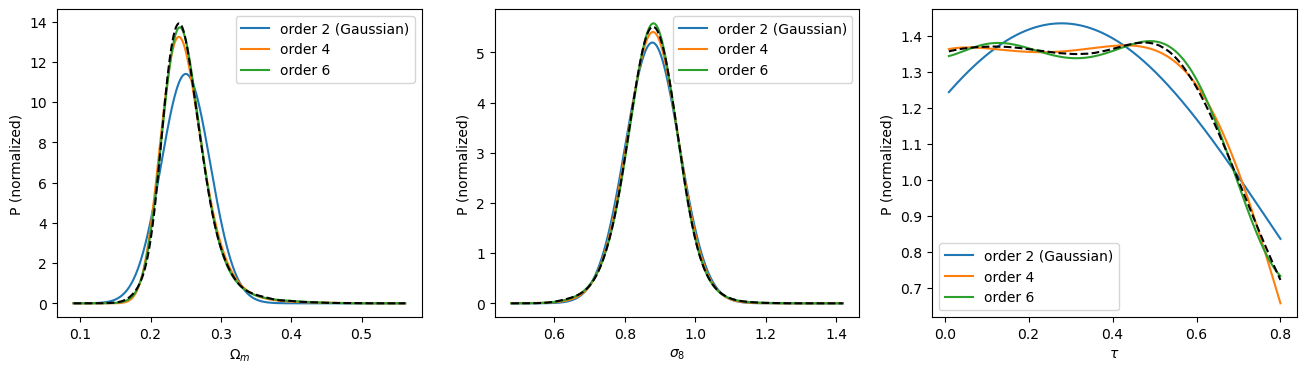

In [7]:
# library for moments decomposition:
import pymaxent
# parameter that we are interested in:
params = ['omegam', 'sigma8', 'tau']
fig, ax = plt.subplots(1,len(params), figsize = (16,4))
for ind, name in enumerate(params):
    # get index:
    par_ind = chain.index[name]
    # get the posterior:
    posterior = chain.get1DDensityGridData(par_ind)
    posterior.normalize()
    # get the weights, mean and moments of the samples:
    total_weights = np.sum(chain.weights)
    mean = np.dot(chain.weights, chain.samples[:,par_ind])/total_weights
    moments = [ np.dot(chain.weights, (chain.samples[:,par_ind])**k)/total_weights for k in range(100)]
    # reconstruct the PDF from the moments:
    sol1,lambdas1 = pymaxent.reconstruct(moments[:3],bnds=posterior.bounds())
    sol2,lambdas2 = pymaxent.reconstruct(moments[:5],bnds=[np.amin(posterior.x), np.amax(posterior.x)])
    sol3,lambdas3 = pymaxent.reconstruct(moments[:7],bnds=[np.amin(posterior.x), np.amax(posterior.x)])
    # plot:
    x = posterior.x
    ax[ind].plot(x, sol1(x), label='order 2 (Gaussian)')
    ax[ind].plot(x, sol2(x), label='order 4')
    ax[ind].plot(x, sol3(x), label='order 6')
    ax[ind].plot(x, posterior.P, ls='--', color='k')
    ax[ind].set_xlabel('$'+chain._parAndNumber(par_ind)[1].label+'$');
    ax[ind].set_ylabel('P (normalized)')
    ax[ind].legend()

The second order moment approximation of the pdf is its Gaussian approximation. As we go to higher orders the approximation of the pdf improves to the point that it becomes hardly distinguishable from the true one.

To test the agreement of the posterior estimates we then follow the idea of the Gelman Rubin test (http://www.stat.columbia.edu/~gelman/research/published/itsim.pdf). This compares the variation of the mean across a pool of chains with the expected variation of the mean under the pdf that is being sampled:
\begin{align}
R-1 = \frac{{\rm Var}_c ({\rm Mean}_s(\theta))}{{\rm Mean}_c ({\rm Var}_s(\theta)) }
\end{align}
where the subscript $c$ means that the statistics is computed across chains while the subscrit $s$ indicates that it is computed across samples.

We then consider one parameter and compute $R-1$ as a function of the length of the chain:

In [8]:
# preparation:
param_name = 'omegam'
param_ind = chain.index[param_name]
# get separate chains:
chains = utilities.get_separate_mcsamples(chain)
# get the maximum number of samples:
max_elements = np.log10(np.amin([len(ch.samples) for ch in chains]))
# get the number of samples that can be varied:
num_el_fine = np.logspace(1, max_elements,1000).astype('int')
num_el_fine = np.unique(num_el_fine)
num_el_coarse = np.logspace(1, np.floor(max_elements),4).astype('int')
num_el_coarse = np.unique(num_el_coarse)

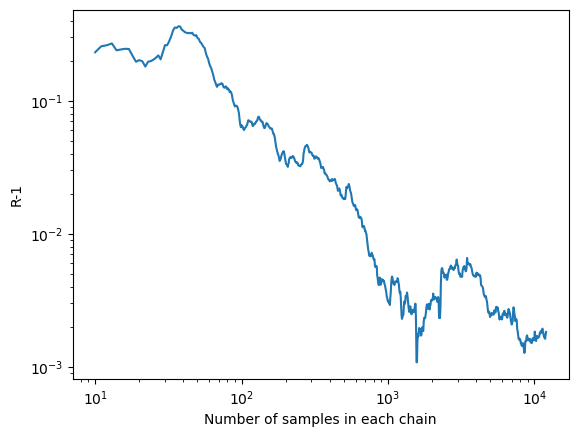

In [9]:
# Plot with R-1 for one parameter (notice that we use a lower level function)
samples = [ch.samples[:, param_ind] for ch in chains]
weights = [ch.weights for ch in chains]
results_GR = []
for ind in range(len(num_el_fine)):
    temp_samples = [ samps[0:num_el_fine[ind]] for samps in samples]
    temp_weights = [ wh[0:num_el_fine[ind]] for wh in weights]
    results_GR.append(chains_convergence.GR_test_from_samples(temp_samples, temp_weights)[0])
results_GR = np.array(results_GR)
# plot:
plt.plot(num_el_fine, results_GR)
plt.xlabel('Number of samples in each chain')
plt.ylabel('R-1')
plt.xscale('log')
plt.yscale('log')

As we can see $R-1$ decreases roughly as a power law in the number of samples and converges toward zero.
The idea is that for small sample sizes fluctuations across chains are larger and our knowledge of the distribution is worse.

We then generalize this test to higher moments, comparing their variation between chains in units of their variance within the pdf that we are sampling:
\begin{align}
R_n(\theta_0)-1 = \frac{{\rm Var}_c ({\rm Mean}_s(\theta-\theta_0)^n)}{{\rm Mean}_c ({\rm Var}_s(\theta-\theta_0)^n) }
\end{align}
we then plot the behavior of this estimator when applied to the variance and skewness.

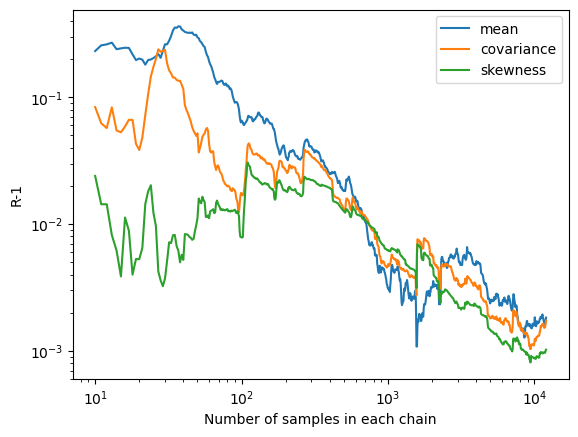

In [10]:
# application to variance and skewness
results_Rn = []
for ind in range(len(num_el_fine)):
    temp_samples = [ samps[0:num_el_fine[ind]] for samps in samples]
    temp_weights = [ wh[0:num_el_fine[ind]] for wh in weights]
    results_Rn.append([chains_convergence.GRn_test_1D_samples(temp_samples, temp_weights, n) for n in range(2,4)])
results_Rn = np.array(results_Rn)
# plot:
plt.plot(num_el_fine,results_GR, label='mean')
plt.plot(num_el_fine,results_Rn[:,0], label='covariance')
plt.plot(num_el_fine,results_Rn[:,1], label='skewness')
plt.xlabel('Number of samples in each chain')
plt.ylabel('R-1')
plt.xscale('log')
plt.yscale('log')
plt.legend();

As we can see at these orders all the three estimators show power law improvement.
We can also apreciate that random fluctuations in one might not correspont to random fluctuations in another moment.
As we can see around a chain length of 1000 points the mean estimator has a dip, probably due to a random fluctuation. That is not seen in the variance of skewness that show no improvement.

Considering the worse of these result as an indication of overall quality would be, in this case, a good choice!

We now turn to multiple dimensions. In this case moments become tensors and finding the worse known parameter mode is not trivial anymore and becomes harder as the order of the problem increases.

The generalization of the Gelman-Rubin test to multiple dimensions is discussed in
(http://www.stat.columbia.edu/~gelman/research/published/brooksgelman2.pdf).

The idea is to compute the covariance of the mean across different chains and compare it to the mean chains variance.
We define the covariance of the mean as $C_{ij} \equiv {\rm Cov}_c({\rm Mean}_s(\theta))_{ij}$ and the mean covariance as $M_{ij}\equiv {\rm Mean}_c[{\rm Cov}_s(\theta)_{ij}]$.
These are not scalar quantities but matrices.
Hence we bound variations by:
\begin{align}
R-1 = {\rm max_{\theta}}\frac{C_{ij} \theta^i \theta^j}{M_{ij}\theta^i \theta^j}
\end{align}
for all parameters $\theta$. 
Implicit in this is that we are conservative in quality control and we enforce the GR test on the linear combination of parameters that has biggest deviations.
This equation can be solved analytically and becomes:
\begin{align}
R-1 = {\rm max} \left( {\rm eig} ( C M^{-1}) \right)
\end{align}
which is the usual form for this test.

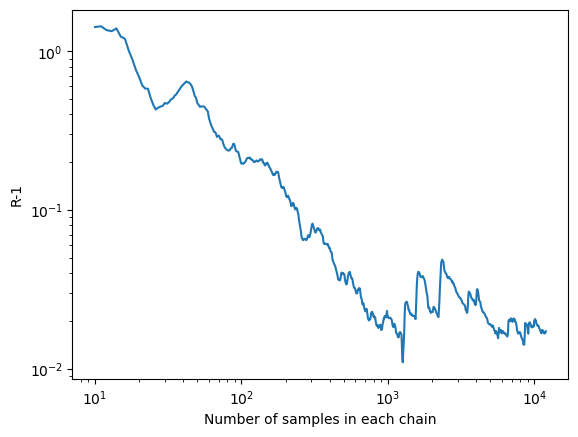

In [11]:
param_ind = [chain.index[name] for name in chain.getParamNames().getRunningNames()]
samples = [ch.samples[:, param_ind] for ch in chains]
weights = [ch.weights for ch in chains]
results_full_GR = []
for ind in range(len(num_el_fine)):
    temp_samples = [ samps[0:num_el_fine[ind]] for samps in samples]
    temp_weights = [ wh[0:num_el_fine[ind]] for wh in weights]
    results_full_GR.append(chains_convergence.GR_test_from_samples(temp_samples, temp_weights)[0])
results_full_GR = np.array(results_full_GR)
plt.plot(num_el_fine, results_full_GR)
plt.xlabel('Number of samples in each chain')
plt.ylabel('R-1')
plt.xscale('log')
plt.yscale('log')

As we see this result is an order of magnitude worse than the 1D case that we have considered above.
Let's compare what we obtain in the full parameter space with what we would get by doing one parameter at the time (and looking at the worse one):

In [12]:
chains_convergence.GR_test(chain)[0]

0.01702876206225704

In [13]:
np.amax([chains_convergence.GR_test(chain, param_names=[name])[0] for name in running_names])

0.009251157131172943

which is optimistic by a factor 2. 
This tells us that in the multidimensional case the GR test should never be done on the single parameters as that would miss all sampling errors that are correlated across parameters.

We can generalize the GR test to multidimensional moments in the following way.
Build the $k$ order tensor of parameter differences around a point:
\begin{align}
Q^{(k)} \equiv Q_{i_1, \dots, i_k} \equiv (\theta_{i_1} -\tilde{\theta}_{i_1}) \cdots (\theta_{i_k} -\tilde{\theta}_{i_k})
\end{align}
build the first tensor encoding the covariance across chains of the $k$ order moment:
\begin{align}
V_M = {\rm Var}_c (E_s [Q^{(k)}])
\end{align}
which is a $2k$ rank tensor of dimension $n$ and then build the second tensor encoding the mean in chain moment:
\begin{align}
M_V = {\rm Mean}_c (E_s[(Q^{(k)}-E_s[Q^{(k)}])\otimes(Q^{(k)}-E_s[Q^{(k)}])])
\end{align}
where we have suppressed all indexes to not crowd the notation (that should still be clear).

Notice that, if we are performing this test at order $k$ then the rank of the tensors $V_M$ and $M_V$ is $2k$.

We now seek to maximize this over parameters:
\begin{align}
R_n -1 \equiv {\rm max}_\theta \frac{V_M \theta^{2k}}{M_V \theta^{2k}}
\end{align}
where $\theta^{2k}$ is the tensor product of $\theta$ for $2k$ times.
Differently from the $2D$ case this problem has no solution in terms of eigenvalues of tensors so far.

Since there is no easy solution we brute force maximize this ratio. 
We first notice that the problem is scale invariant, i.e. $\theta \rightarrow \alpha \theta$ leaves $R_n -1$ invariant. 
Because of scale invariance we can maximize $R_n -1$ on the sphere and we do so by using specialized algorithms (https://www.pymanopt.org).
The limitation for this approach is that it becomes too slow to do at high orders.

In [14]:
results_full_GR2 = []
num_el_fine2 = num_el_fine[::10]
for ind in range(len(num_el_fine2)):
    temp_samples = [ samps[0:num_el_fine2[ind]] for samps in samples]
    temp_weights = [ wh[0:num_el_fine2[ind]] for wh in weights]
    results_full_GR2.append(chains_convergence.GRn_test_from_samples(temp_samples, temp_weights, n=2)[0])
results_full_GR2 = np.array(results_full_GR2)

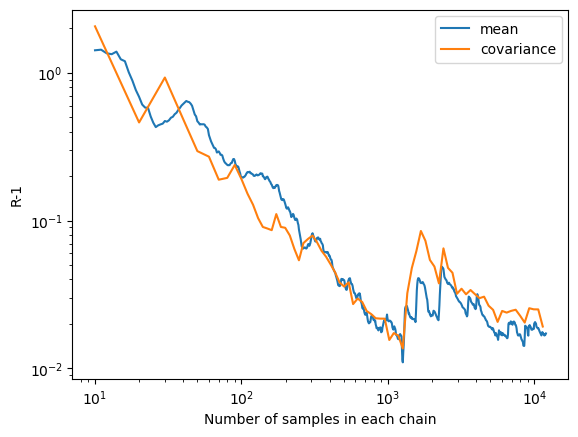

In [15]:
plt.plot(num_el_fine, results_full_GR, label='mean')
plt.plot(num_el_fine2, results_full_GR2, label='covariance')
plt.xlabel('Number of samples in each chain')
plt.ylabel('R-1')
plt.xscale('log')
plt.yscale('log')
plt.legend();

The time it took to produce the plot above should convince you of the scalability problems as a function of moment order. I am currently looking at better algorithm to solve this problem and would warmly welcome contributions.

Finally let us compute the final test for the mean and the covariance for the full length chains:

In [16]:
GR_val, GR_par = chains_convergence.GR_test(chains)
print(GR_val)

0.01702876206225704


In [17]:
GR2_val, GR2_par = chains_convergence.GRn_test(chains, n=2)
print(GR2_val)

0.020665940511367345


That tells us that the sampling error on the mean are at the 2.7% level while the covariance is at the 1% level.

Overall we see that we can bound sampling errors on the mean and covariance in units of their respective covariances. Althought these do not provide a sufficient convergence cryterium they can be used to make quantitative statements on the quality of the first few moments of the distribution.